In [1]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Specific for luca's computer
    %cd "/content/drive/Othercomputers/Min MacBook Pro/INFO381-GitHub"
    using_colab = True
except:
    print("Not using Google Colab")
    using_colab = False

Mounted at /content/drive
/content/drive/Othercomputers/Min MacBook Pro/INFO381-GitHub


In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-q5aw9hs5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-q5aw9hs5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369550 sha256=bd6a0d900f979253a189d9a0b649673c0df2b929fdda3f5c73120eb92855f1fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-189uwyrr/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [26]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import clip
from skimage.transform import resize

from utils import get_dataloaders
from model_definitions import CLIPClassifier

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Load CLIP preprocessing and CNN Transform**

In [5]:
clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)

cnn_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 104MiB/s]


**Load dataloaders with both transforms**

In [7]:
cnn_train_loader, cnn_test_loader = get_dataloaders(zip_path="fake_vs_real.zip", batch_size=32, split='both', transform=cnn_transform)
clip_train_loader, clip_test_loader = get_dataloaders(zip_path="fake_vs_real.zip", batch_size=32, split='both', transform=preprocess_clip)

Running in Google Colab
Running in Google Colab


In [8]:
#train_loader.dataset.transform = resize_transform

In [9]:
cnn_model = models.resnet18(pretrained=False)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 2)
cnn_model.load_state_dict(torch.load("models/resnet18_cnn.pth", map_location=device))
cnn_model.eval().to(device)
cnn_model.input_size = (512, 512)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
clip_classifier = CLIPClassifier(clip_model, embed_dim=512, num_classes=2).to(device)
clip_classifier.load_state_dict(torch.load("models/clip_classifier_10epochs.pth", map_location=device))
clip_classifier.eval()
clip_classifier.input_size = (224, 224)

In [11]:
def get_image_by_class_and_index(dataloader, class_name, index, transform_override=None):
    dataset = dataloader.dataset
    class_to_idx = dataset.class_to_idx
    class_idx = class_to_idx[class_name]
    samples = [(p, l) for p, l in dataset.samples if l == class_idx]
    path, _ = samples[index]
    img = dataset.loader(path)
    transform = transform_override if transform_override else dataset.transform
    img_tensor = transform(img)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    return img_np, img_tensor.unsqueeze(0), path

In [17]:
# Get a specific image (e.g., 3rd image from the "real" class)
img_np, img_tensor, img_path = get_image_by_class_and_index(clip_train_loader, class_name="fake", index=2)

print("Selected image:", img_path)

Selected image: /content/fake_vs_real/train/fake/10002.jpg


In [27]:
def generate_masks(model, N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s).astype(int)
    up_size = ((s + 1) * cell_size).astype(int)

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        upsampled = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
        masks[i] = upsampled[x:x + model.input_size[0], y:y + model.input_size[1]]

    masks = masks.reshape(N, 1, *model.input_size)
    return masks


In [28]:
def explain(model, inp, masks, N, p1, batch_size=100):
    with torch.no_grad():
        inp_np = inp.cpu().numpy()  # (1, 3, H, W)
        inp_np = inp_np.squeeze(0)  # -> (3, H, W)
        masked = masks * inp_np  # (N, 1, H, W) * (3, H, W) → (N, 3, H, W)

        preds = []
        for i in tqdm(range(0, N, batch_size), desc='Explaining'):
            batch = torch.from_numpy(masked[i:i+batch_size]).to(device).float()
            out = model(batch)
            probs = torch.softmax(out, dim=1).cpu().numpy()
            preds.append(probs)

        preds = np.concatenate(preds, axis=0)
        sal = preds.T @ masks.reshape(N, -1)
        sal = sal.reshape(2, *model.input_size)  # 2 classes
        sal = sal / N / p1
    return sal


In [29]:
def run_rise_explanation(model, dataloader, class_name, image_index, transform_override=None, model_name="Model", N=2000, s=8, p1=0.5):
    # Get image and transform if needed
    img_np, img_tensor, image_path = get_image_by_class_and_index(
        dataloader, class_name=class_name, index=image_index, transform_override=transform_override
    )

    # Generate masks & saliency
    masks = generate_masks(model, N, s, p1)
    saliency = explain(model, img_tensor.to(device), masks, N, p1)

    # Predict
    with torch.no_grad():
        output = model(img_tensor.to(device))
        pred_class = torch.argmax(output, dim=1).item()
        class_names = dataloader.dataset.classes
        pred_label = class_names[pred_class]

    # Print and plot
    print(f"{model_name.upper()} predikerer at bildet er: {pred_label.upper()} (klasse {pred_class})")
    print(f"Bilde valgt fra: {image_path}")

    plt.figure(figsize=(10, 5))
    plt.title(f"{model_name} + RISE Explanation for `{pred_label}`")
    plt.imshow(img_np)
    plt.imshow(saliency[pred_class], cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()


Explaining: 100%|██████████| 20/20 [12:04<00:00, 36.22s/it]


CNN predikerer at bildet er: FAKE (klasse 0)
Bilde valgt fra: /content/fake_vs_real/train/fake/10002.jpg


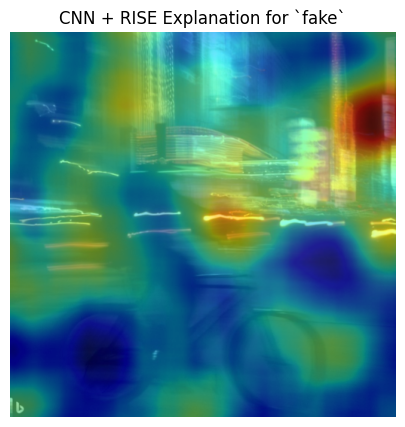

In [32]:
run_rise_explanation(
    model=cnn_model,
    dataloader=cnn_train_loader,
    class_name="fake",
    image_index=2,
    model_name="CNN"
)

Explaining: 100%|██████████| 20/20 [05:13<00:00, 15.70s/it]


CLIP predikerer at bildet er: FAKE (klasse 0)
Bilde valgt fra: /content/fake_vs_real/train/fake/10002.jpg


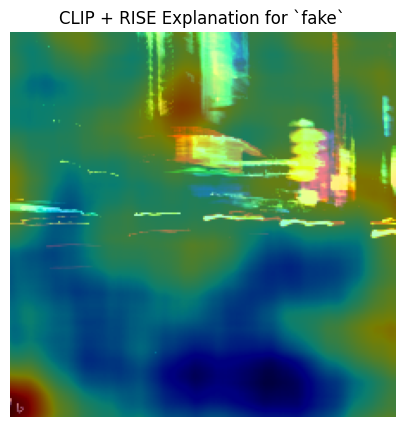

In [30]:
run_rise_explanation(
    model=clip_classifier,
    dataloader=clip_train_loader,
    class_name="fake",
    image_index=2,
    transform_override=preprocess_clip,
    model_name="CLIP"
)

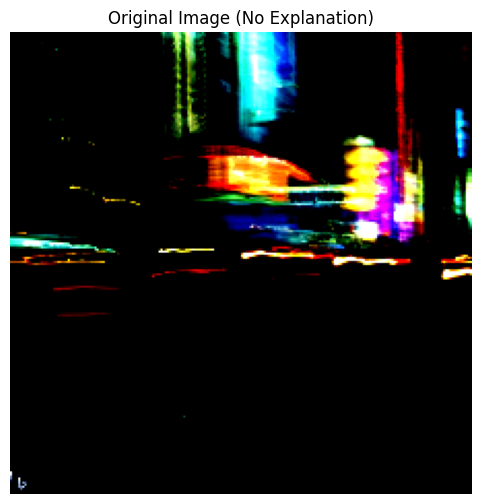

In [31]:
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.title("Original Image (No Explanation)")
plt.axis('off')
plt.show()